In [94]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier

In [95]:
import optuna
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    f1_score,
    jaccard_score,
    make_scorer,
)
import matplotlib.pyplot as plt


## Read fingerprint file and experimental file

read fingerprint file and experiment data file

In [96]:
receptors = pd.read_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file.csv') # selected only existing binding receptors left
fingerprints = pd.read_csv('../MACCS_fingerprints.csv')
print(receptors.head())



  receptor gprotein       drug        Emax    Emax_SE     TCoeff  TCoeff_SE  \
0    5HT1A      GoB  25C-NBOMe   13.047601   1.862662   7.863330   0.215495   
1    5HT1D      Gi2  25C-NBOMe   61.560000  16.200000   7.308909   0.275469   
2    5HT2A    BArr2  25C-NBOMe  126.520000   2.660000  10.852095   0.045687   
3    5HT2A      G11  25C-NBOMe   97.880000   1.930000  11.570638   0.051133   
4    5HT2A      G15  25C-NBOMe   89.690000   2.150000  11.482661   0.057973   

     logEmEC  logEmEc_Lower  logEmEc_Upper    pEC50  pEC50_SE  N  
0   7.866311       7.488600       8.235079  6.75078  0.310814  3  
1   7.319299       6.826673       7.780756  5.53000  0.360000  3  
2  10.852159      10.772931      10.931195  8.75000  0.070000  3  
3  11.570694      11.482045      11.659174  9.58000  0.080000  3  
4  11.482744      11.382207      11.583032  9.53000  0.090000  3  


### Experimental data processing

binarize the experiment data file -> create multilabel for receptors

In [97]:
# collect receptors for each drug
drug_receptor_mapping = receptors.groupby('drug')['receptor'].apply(list).reset_index()
print(drug_receptor_mapping.head())

         drug                                           receptor
0   25C-NBOMe  [5HT1A, 5HT1D, 5HT2A, 5HT2A, 5HT2A, 5HT2A, 5HT...
1    25I-NBMD  [5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT1B, 5HT1B, 5HT...
2   25I-NBOMe  [5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT1D, 5HT...
3  25T7-NBOMe  [5HT1A, 5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT...
4  4-AcO-MALT  [5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT...


In [98]:
# binarize the receptors
mlb = MultiLabelBinarizer()
receptor_labels = mlb.fit_transform(drug_receptor_mapping['receptor'])

In [99]:
drug_receptor_label = pd.concat([drug_receptor_mapping, pd.DataFrame(receptor_labels, columns=mlb.classes_)], axis=1)
print(drug_receptor_label.head())

         drug                                           receptor  5HT1A  \
0   25C-NBOMe  [5HT1A, 5HT1D, 5HT2A, 5HT2A, 5HT2A, 5HT2A, 5HT...      1   
1    25I-NBMD  [5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT1B, 5HT1B, 5HT...      1   
2   25I-NBOMe  [5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT1D, 5HT...      1   
3  25T7-NBOMe  [5HT1A, 5HT1A, 5HT1A, 5HT1D, 5HT1D, 5HT1D, 5HT...      1   
4  4-AcO-MALT  [5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1A, 5HT1B, 5HT...      1   

   5HT1B  5HT1D  5HT1E  5HT1F  5HT2A  5HT2B  5HT2C  ...  Alpha2A  Alpha2B  \
0      0      1      0      0      1      1      1  ...        0        0   
1      1      1      1      1      1      1      1  ...        0        0   
2      0      1      1      1      1      1      1  ...        0        0   
3      0      1      0      1      1      1      1  ...        0        0   
4      1      1      1      1      1      1      1  ...        0        0   

   Alpha2C  Beta2AR  Beta3AR  DRD1  DRD2  DRD3  DRD4  DRD5  
0        0        0      

In [100]:
drug_label = drug_receptor_label.drop(columns=['receptor'])
print(drug_label.head())
# drug_label.to_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file_multilabel.csv', index=False)

drug_dict = drug_label.to_dict()
print(drug_dict)

         drug  5HT1A  5HT1B  5HT1D  5HT1E  5HT1F  5HT2A  5HT2B  5HT2C  5HT5A  \
0   25C-NBOMe      1      0      1      0      0      1      1      1      0   
1    25I-NBMD      1      1      1      1      1      1      1      1      0   
2   25I-NBOMe      1      0      1      1      1      1      1      1      1   
3  25T7-NBOMe      1      0      1      0      1      1      1      1      1   
4  4-AcO-MALT      1      1      1      1      1      1      1      1      1   

   ...  Alpha2A  Alpha2B  Alpha2C  Beta2AR  Beta3AR  DRD1  DRD2  DRD3  DRD4  \
0  ...        0        0        0        0        0     0     1     0     0   
1  ...        0        0        0        0        0     0     0     0     0   
2  ...        0        0        0        0        0     0     0     1     0   
3  ...        0        0        0        0        0     0     0     1     0   
4  ...        0        0        0        0        0     0     1     1     0   

   DRD5  
0     0  
1     0  
2     0  
3   

### Fingerprint data processing

In [101]:
# Extract the names (first column)
drug_names_fingerprints = fingerprints['Name']
fingerprints_detail = fingerprints.drop('Name', axis=1)  # Drop the name column by index

# Create a dictionary where names are keys and fingerprints are lists of values
# csv_dict = {name: fingerprint.tolist() for name, fingerprint in zip(drug_names_fingerprints, fingerprints_detail.values)}


### Merge feature and labels

merge features and labels -> to ensure the features and labels match based on drugs

In [102]:
# merge the two dataframes based on the drug name
data_merged = pd.merge(fingerprints, drug_label, left_on="Name", right_on="drug").drop(
    columns=["Name"]
)
data_merged.to_csv('/Users/xiaomuou620/Desktop/PRIVATE_DATA/data_merged.csv', index=False)

print(data_merged.shape)

(40, 192)


# Training

In [103]:
X = data_merged.drop(columns=['drug'] + list(mlb.classes_))
y = data_merged[list(mlb.classes_)]

print(X.shape, y.shape)


(40, 167) (40, 24)


In [104]:
print(X.head())

   0  1  2  3  4  5  6  7  8  9  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  0  0  0  ...    1    1    1    0    1    1    1    1   
1  0  0  0  0  0  0  0  0  0  0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0  0  ...    1    1    0    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0  0  ...    1    1    0    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0  0  ...    1    1    0    1    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    0  
4    1    0  

[5 rows x 167 columns]


## Optuna + Nested CV

In [105]:
# Nested cross-validation setup
outer_ncv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = KFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(
        hamming_loss, greater_is_better=False
    )  # Minimize Hamming loss
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return -cv_scores.mean() # -cv mean because make_scorer is greater_is_better=False, which will give negative values of hamming loss


In [106]:
# Outer loop: Statistical evaluation
outer_scores = []
ncv_label_scores = {label: [] for label in y.columns}


for train_index, test_index in outer_ncv.split(X, y):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Get predicted probabilities
    # y_test_pred_proba = best_rf_classifier.predict_proba(X_test)

    # Convert predicted probabilities to predicted labels 
    y_test_pred = best_rf_classifier.predict(X_test) # could change to predict_proba using different threshold to predict labels

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "hamming_loss": hamming_loss(y_test, y_test_pred),
            "f1_micro": f1_score(y_test, y_test_pred, average="micro"),
            "jaccard_samples": jaccard_score(y_test, y_test_pred, average="samples"),
        }
    )
    

    # Calculate metrics for each label
    for label in y.columns:
        ncv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )
        
    
# Calculate mean and standard deviation for overall metrics
ncv_metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in ncv_metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
    

[I 2025-01-03 11:52:50,168] A new study created in memory with name: no-name-9756985b-4387-4053-8616-5d1943cf6890


[I 2025-01-03 11:52:50,699] Trial 0 finished with value: 0.11785714285714284 and parameters: {'n_estimators': 96, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.11785714285714284.
[I 2025-01-03 11:52:50,983] Trial 1 finished with value: 0.11765873015873016 and parameters: {'n_estimators': 63, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 0.11765873015873016.
[I 2025-01-03 11:52:51,333] Trial 2 finished with value: 0.13551587301587303 and parameters: {'n_estimators': 66, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.11765873015873016.
[I 2025-01-03 11:52:51,431] Trial 3 finished with value: 0.12420634920634918 and parameters: {'n_estimators': 18, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 0.11765873015873016.
[I 2025-

Accuracy: Mean = 0.07, Std = 0.06
Hamming_loss: Mean = 0.13, Std = 0.03
F1_micro: Mean = 0.89, Std = 0.03
Jaccard_samples: Mean = 0.79, Std = 0.05


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'n_estimators': 23, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False}


### Evaluation

"accuracy", "hamming_loss", "f1_score", "jaccard_score"

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: Mean = 0.07, Std = 0.06
Hamming_loss: Mean = 0.13, Std = 0.03
F1_micro: Mean = 0.89, Std = 0.03
Jaccard_samples: Mean = 0.79, Std = 0.05

Metrics for label: 5HT1A
Accuracy: Mean = 0.93, Std = 0.06
Hamming_loss: Mean = 0.07, Std = 0.06
F1_score: Mean = 0.96, Std = 0.03
Jaccard_score: Mean = 0.93, Std = 0.06

Metrics for label: 5HT1B
Accuracy: Mean = 0.93, Std = 0.10
Hamming_loss: Mean = 0.07, Std = 0.10
F1_score: Mean = 0.96, Std = 0.06
Jaccard_score: Mean = 0.93, Std = 0.10

Metrics for label: 5HT1D
Accuracy: Mean = 1.00, Std = 0.00
Hamming_loss: Mean = 0.00, Std = 0.00
F1_score: Mean = 1.00, Std = 0.00
Jaccard_score: Mean = 1.00, Std = 0.00

Metrics for label: 5HT1E
Accuracy: Mean = 0.88, Std = 0.08
Hamming_loss: Mean = 0.12, Std = 0.08
F1_score: Mean = 0.93, Std = 0.05
Jaccard_score: Mean = 0.88, Std = 0.08

Metrics for label: 5HT1F
Accuracy: Mean = 0.97, Std = 0.05
Hamming_loss: Mean = 0.03, Std = 0.05
F1_score: Mean = 0.99, Std = 0.03
Jaccard_score: Mean = 0.97, Std = 0.0

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

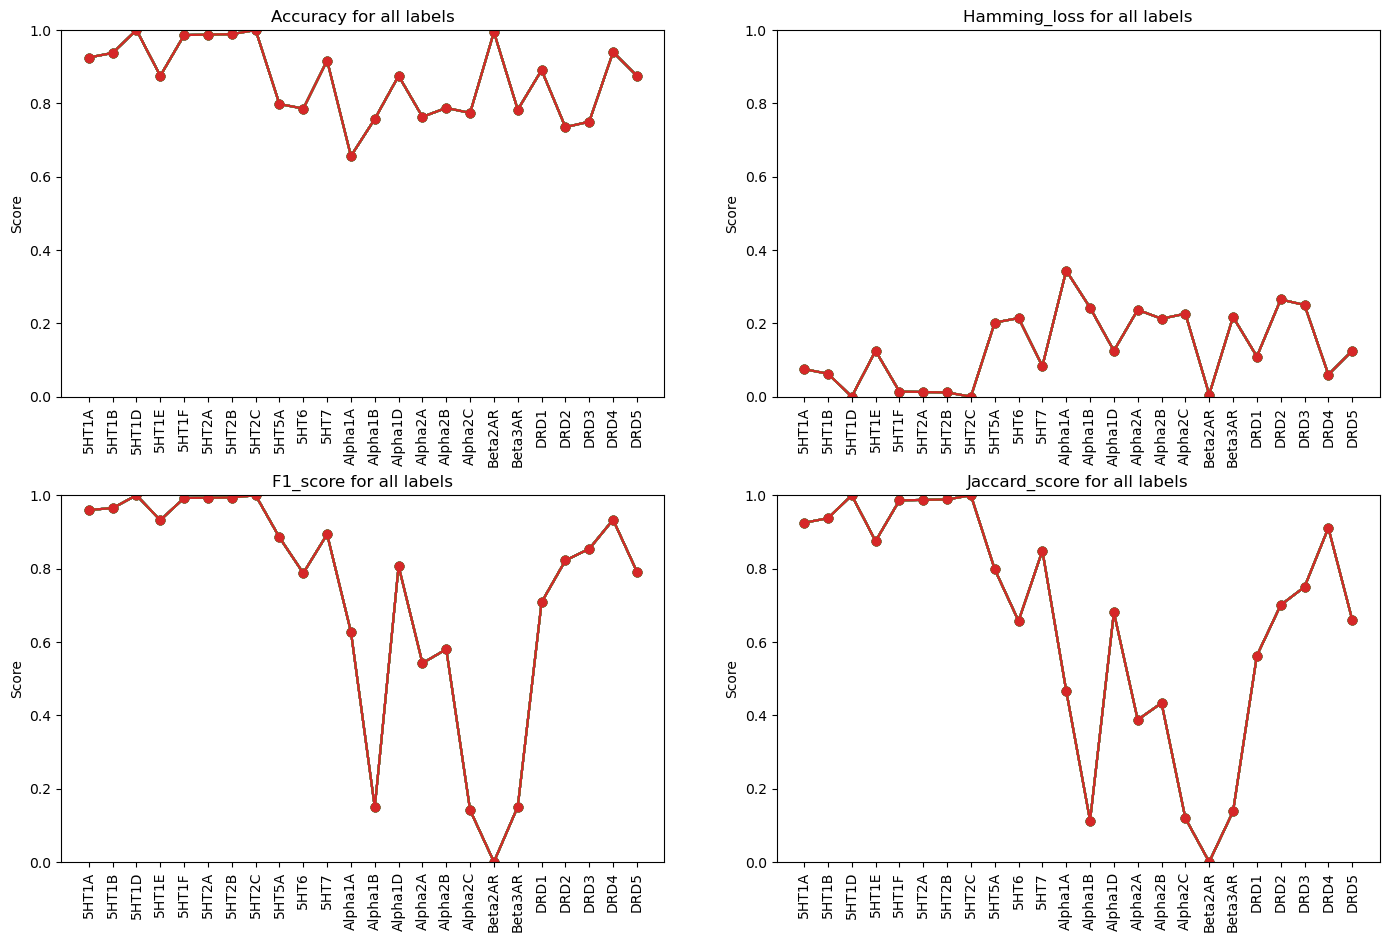

In [108]:
# Calculate mean and standard deviation for overall metrics
metrics = {key: [score[key] for score in outer_scores] for key in outer_scores[0]}
for metric, values in metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )
    
# Calculate mean and standard deviation for each label's metrics
for label, scores in ncv_label_scores.items():
    print(f"\nMetrics for label: {label}")
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    for metric, values in label_metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )
    

# Calculate mean and standard deviation for each label's metrics
ncv_label_metrics_summary = {}
for label, scores in ncv_label_scores.items():
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    ncv_label_metrics_summary[label] = {
        metric: (np.mean(values), np.std(values))
        for metric, values in label_metrics.items()
    }

    # Calculate metrics for each label
    for label in y.columns:
        ncv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )

# Plotting the metrics for each label
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    for label in y.columns:
        means = [ncv_label_metrics_summary[label][metric][0] for label in y.columns]
        stds = [ncv_label_metrics_summary[label][metric][1] for label in y.columns]
        ax.plot(y.columns, means, marker="o", label=label)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    # ax.legend()
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    means = [ncv_label_metrics_summary[label][metric][0] for label in y.columns]
    stds = [ncv_label_metrics_summary[label][metric][1] for label in y.columns]

    ax.plot(range(len(y.columns)), means, marker="o")
    ax.fill_between(
        range(len(y.columns)),
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()


## Optuna + CV

In [109]:
# cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Define the objective function for without Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_train)
    
    return hamming_loss(y_train, y_pred)

In [110]:
cv_scores = []
cv_label_scores = {label: [] for label in y.columns}

for train_index, test_index in cv.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Hyperparameter search
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = best_rf_classifier.predict(X_test)

    # Evaluate the model
    cv_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "hamming_loss": hamming_loss(y_test, y_test_pred),
            "f1_micro": f1_score(y_test, y_test_pred, average="micro"),
            "jaccard_samples": jaccard_score(y_test, y_test_pred, average="samples"),
        }
    )

    # Calculate metrics for each label
    for label in y.columns:
        cv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )

# Calculate mean and standard deviation for overall metrics
cv_metrics = {key: [score[key] for score in cv_scores] for key in cv_scores[0]}
for metric, values in cv_metrics.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )


[I 2025-01-03 11:54:04,341] A new study created in memory with name: no-name-621c2845-a125-49d8-a641-3bbd6b525626
[I 2025-01-03 11:54:04,379] Trial 0 finished with value: 0.08333333333333333 and parameters: {'n_estimators': 33, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.08333333333333333.
[I 2025-01-03 11:54:04,462] Trial 1 finished with value: 0.022135416666666668 and parameters: {'n_estimators': 81, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.022135416666666668.
[I 2025-01-03 11:54:04,495] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 28, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.0.
[I 2025-01-03 11:54:04,551] Trial 3 finished with value: 0.052083333333333336 and parameters: {'n_estimators': 57, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf

Accuracy: Mean = 0.07, Std = 0.06
Hamming_loss: Mean = 0.13, Std = 0.03
F1_micro: Mean = 0.89, Std = 0.03
Jaccard_samples: Mean = 0.79, Std = 0.05


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predic

Accuracy: Mean = 0.07, Std = 0.06
Hamming_loss: Mean = 0.13, Std = 0.03
F1_micro: Mean = 0.89, Std = 0.03
Jaccard_samples: Mean = 0.79, Std = 0.05

Metrics for label: 5HT1A
Accuracy: Mean = 0.90, Std = 0.09
Hamming_loss: Mean = 0.10, Std = 0.09
F1_score: Mean = 0.94, Std = 0.05
Jaccard_score: Mean = 0.90, Std = 0.09

Metrics for label: 5HT1B
Accuracy: Mean = 0.93, Std = 0.10
Hamming_loss: Mean = 0.07, Std = 0.10
F1_score: Mean = 0.96, Std = 0.06
Jaccard_score: Mean = 0.93, Std = 0.10

Metrics for label: 5HT1D
Accuracy: Mean = 1.00, Std = 0.00
Hamming_loss: Mean = 0.00, Std = 0.00
F1_score: Mean = 1.00, Std = 0.00
Jaccard_score: Mean = 1.00, Std = 0.00

Metrics for label: 5HT1E
Accuracy: Mean = 0.93, Std = 0.06
Hamming_loss: Mean = 0.07, Std = 0.06
F1_score: Mean = 0.96, Std = 0.03
Jaccard_score: Mean = 0.92, Std = 0.06

Metrics for label: 5HT1F
Accuracy: Mean = 0.97, Std = 0.05
Hamming_loss: Mean = 0.03, Std = 0.05
F1_score: Mean = 0.99, Std = 0.03
Jaccard_score: Mean = 0.97, Std = 0.0

/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

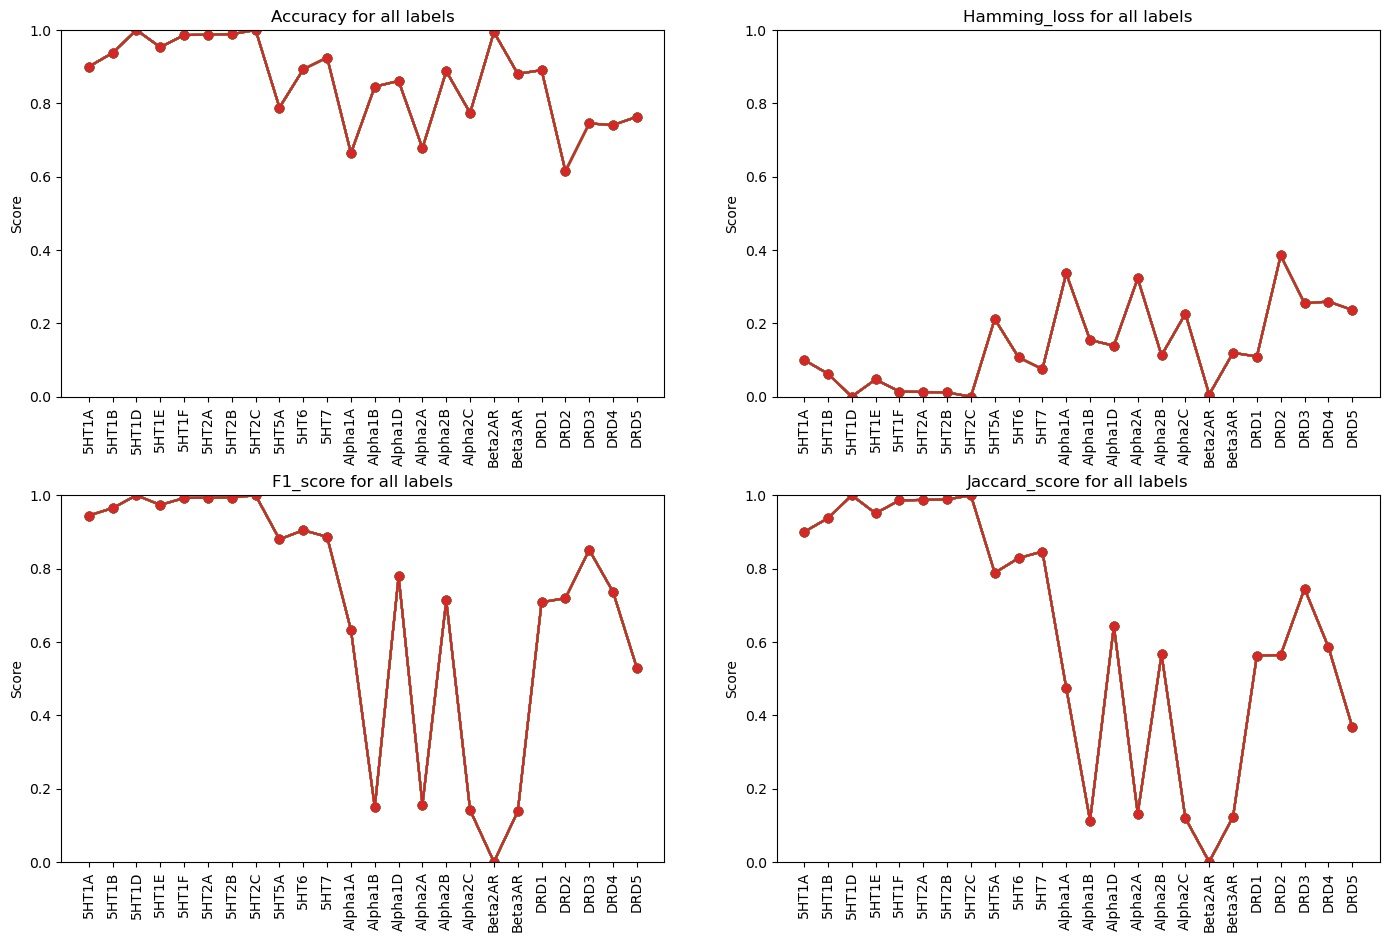

In [111]:
# Calculate mean and standard deviation for overall metrics
metrics_cv = {key: [score[key] for score in cv_scores] for key in cv_scores[0]}
for metric, values in metrics_cv.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Calculate mean and standard deviation for each label's metrics
for label, scores in cv_label_scores.items():
    print(f"\nMetrics for label: {label}")
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    for metric, values in label_metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )


# Calculate mean and standard deviation for each label's metrics
cv_label_metrics_summary = {}
for label, scores in cv_label_scores.items():
    label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    cv_label_metrics_summary[label] = {
        metric: (np.mean(values), np.std(values))
        for metric, values in label_metrics.items()
    }

    # Calculate metrics for each label
    for label in y.columns:
        cv_label_scores[label].append(
            {
                "accuracy": accuracy_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test[label], y_test_pred[:, y.columns.get_loc(label)]
                ),
            }
        )

# Plotting the metrics for each label
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    for label in y.columns:
        means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
        stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]
        ax.plot(y.columns, means, marker="o", label=label)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    # ax.legend()
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
    stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]

    ax.plot(range(len(y.columns)), means, marker="o")
    ax.fill_between(
        range(len(y.columns)),
        np.array(means) - np.array(stds),
        np.array(means) + np.array(stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()


## Nested CV + Simple CV

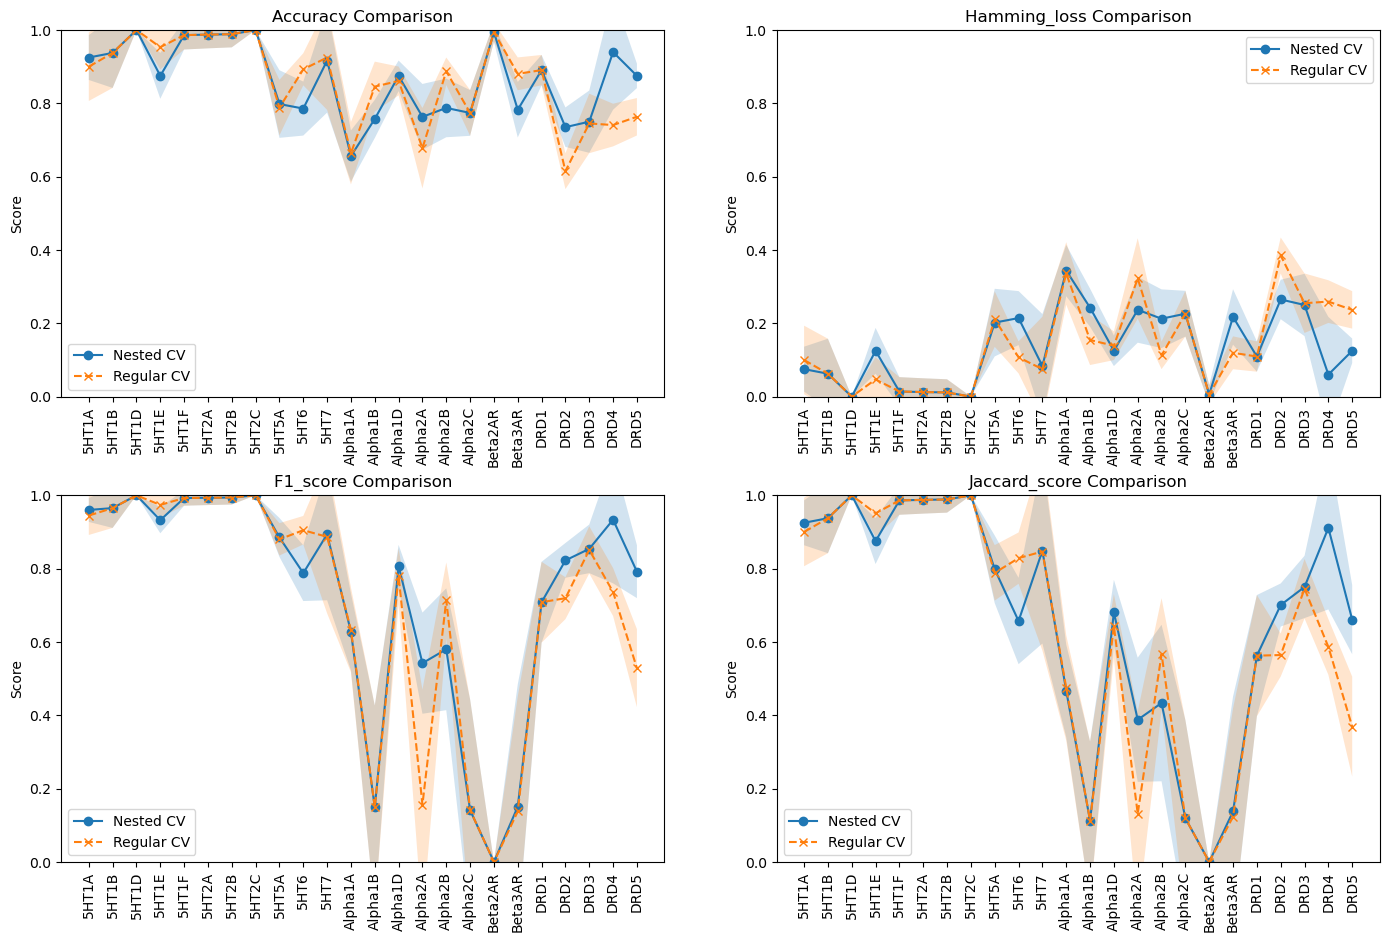

In [112]:
# Combine Nested CV and Regular CV metrics in a single plot
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} Comparison")

    # Nested CV
    nested_means = [ncv_label_metrics_summary[label][metric][0] for label in y.columns]
    nested_stds = [ncv_label_metrics_summary[label][metric][1] for label in y.columns]
    ax.plot(range(len(y.columns)), nested_means, marker="o", label="Nested CV")
    ax.fill_between(
        range(len(y.columns)),
        np.array(nested_means) - np.array(nested_stds),
        np.array(nested_means) + np.array(nested_stds),
        alpha=0.2,
    )

    # Regular CV
    cv_means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
    cv_stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]
    ax.plot(
        range(len(y.columns)), cv_means, marker="x", linestyle="--", label="Regular CV"
    )
    ax.fill_between(
        range(len(y.columns)),
        np.array(cv_means) - np.array(cv_stds),
        np.array(cv_means) + np.array(cv_stds),
        alpha=0.2,
    )

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)
    ax.legend()

plt.show()
